In [1]:
# Cargar librerias
from google.colab import files
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

# librerías Gaussian Naive Bayes
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')

%matplotlib inline

# 1. limpieza y descripcion de las caracteristicas

Se da una descripción clara de los preprocesamientos que se debieron realizar a los datos y cómo se hicieron paso a paso.

In [2]:
# Leer los datos de vino "rojo", estan separados por ";"

# ¡¡Importante!! SUBIR LOS DOS ARCHIVOS A LA VEZ (por comodidad)

uploaded = files.upload() 
wineQuality_red = pd.read_csv(io.BytesIO(uploaded['winequality-red.csv']), sep=";")

# añadir una caracteristica que nos diga que tipo de vino es
wineQuality_red["type"] = 0

# leer los datos de vino "blanco", estan separados por ";"
wineQuality_white = pd.read_csv(io.BytesIO(uploaded['winequality-white.csv']), sep=";")

# añadir una caracteristica que nos diga que tipo de vino es
wineQuality_white["type"] = 1

# fusionar los datasets
wineQuality = pd.concat([wineQuality_red, wineQuality_white], axis="index", ignore_index=True)

# mesclar datos
wineQuality = wineQuality.sample(frac=1, random_state=1)

print("\n quality antes de transformar la variable")
display(wineQuality.quality.value_counts())

# modificar variable objetivo
wineQuality.quality = wineQuality.quality.map({
    3: 1,
    4: 1,
    5: 1,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
})

print("\n quality despues de transformar la variable")
display(wineQuality.quality.value_counts())

Saving winequality-red.csv to winequality-red.csv
Saving winequality-white.csv to winequality-white.csv

 quality antes de transformar la variable


6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


 quality despues de transformar la variable


2    2836
1    2384
3    1277
Name: quality, dtype: int64

In [3]:
# Primer vistazo de la base de datos
wineQuality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
3772,7.6,0.32,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.200000,1,1
6009,5.7,0.24,0.47,6.30,0.069,35.0,182.0,0.99391,3.11,0.46,9.733333,1,1
3464,7.6,0.36,0.44,8.30,0.255,28.0,142.0,0.99580,3.12,0.43,10.200000,2,1
1518,7.4,0.47,0.46,2.20,0.114,7.0,20.0,0.99647,3.32,0.63,10.500000,1,0
3761,9.9,0.49,0.23,2.40,0.087,19.0,115.0,0.99480,2.77,0.44,9.400000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,9.2,0.58,0.20,3.00,0.081,15.0,115.0,0.99800,3.23,0.59,9.500000,1,0
5192,5.6,0.28,0.28,4.20,0.044,52.0,158.0,0.99200,3.35,0.44,10.700000,3,1
3980,7.0,0.23,0.42,5.10,0.042,37.0,144.0,0.99518,3.50,0.59,10.200000,2,1
235,7.2,0.63,0.00,1.90,0.097,14.0,38.0,0.99675,3.37,0.58,9.000000,2,0


In [4]:
# Se identifican cuantos NaN hay por columna
print("NaN por columna: \n")
wineQuality.isna().sum(axis="index")

NaN por columna: 



fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

In [5]:
# Se identifican cuantas filas hay duplicadas y se eliminan. 
print("Filas duplicadas:", wineQuality.duplicated().sum())
wineQuality.drop_duplicates(inplace=True)

Filas duplicadas: 1177


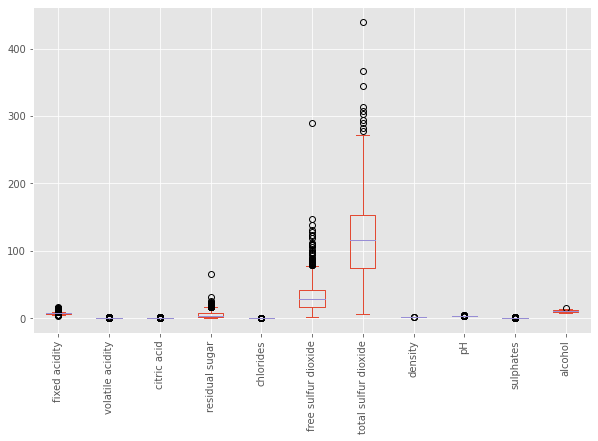

In [6]:
# valores atipicos (sin la variable objetivo ni la variable categorica)
ax = wineQuality.iloc[:, :-2].plot.box(figsize=(10,6))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

En la grafica anterior se observan varias observaciones atipicas, por lo que se eliminaran todas las observaciones atipicas (se considerara una observacion atipica a aquellas que sean mayores a 1.5 veces el rango intercuartilico)

In [7]:
# eliminacion de valores atipicos
Q25 = wineQuality.iloc[:, :-2].quantile(q=0.25, axis="index") # primer quartil
Q75 = wineQuality.iloc[:, :-2].quantile(q=0.75, axis="index") # tercer quartil
IQR = Q75 - Q25 # rango intercuartilico

upper = Q75 + 1.5*IQR
lower = Q25 - 1.5*IQR

# seleccionar filas en las cuales todas sus columnas (menos la objetivo y la categorica) sean mayores o iguales a el limite inferior
# y que todas sus columnas sean (menos la objetivo y la categorica) sean menores o iguales al limite superior
mask = np.all(lower <= wineQuality.iloc[:, :-2], axis=1) & np.all(wineQuality.iloc[:, :-2] <= upper, axis=1)
print("cantidad de valores atipicos:", (~mask).sum())

wineQuality = wineQuality[mask]

cantidad de valores atipicos: 1094


### Preprocesamientos realizados
Se realizaron los siguientes preprocesamientos:
- Se les añadio una columna categorica "type" que indica de que dataset vino ya sea de "red" o de "white" (0 para red y 1 para white)
- Se combinaron los dos datasets de modo que quedo uno solo con los datos de los dos datasets anteriores
- se mesclaron los datos aleatoriamente
- Se verifico si existian NaN pero no se encontro ninguno
- Se verifico si existian filas duplicadas y se encontraron 1177. estas fueron eliminadas
- Se modifico la variable objetivo (quality) ya que esta originalmente tenia 10 clases (1,2,3,...,10) pero no se tenia ningun ejemplo de las clases 1, 2 y 10, a demas de que no estaban repartidas uniformemente. De esta forma ahora nos centraremos en los vinos malos, promedio y buenos
    - las clases 1 a la 5 se fusionaron, ahora seran la clase 1 (vinos malos)
    - la clase 6 ahora sera la clase 2 (vinos promedio)
    - las clases 7 a la 10 ahora seran la clase 3 (vinos buenos)

- se eliminaron valores atipicos (habian 1094 outliers)

**despues de limpiar el dataset se quedo 4226 filas**

## Descripcion de las caracteristicas

Se realiza una descripción de los datos, de las características que los describen y se contextualiza el problema en cuestión, determinando los valores objetivo que se desean predecir. 

<center>

|<p>Caracteristica</p>|<p>Descripción</p>|
|--------|--------|
|<p>fixed acidity</p>|<p align="justify">La acidez fija es el conjunto de ácidos naturales del vino como tartárico, málico, cítrico, <br> succínico y láctico.</p>|
|<p>volatile acidity</p>|<p align="justify">Es la proporción de vinagre que tiene el vino. Es un factor claramente indeseable <br> pero inevitable. </p>|
|<p>citric acid</p>|<p align="justify">Es un acidificante para corregir la acidez y además posee una acción estabilizante. </p>|
|<p>residual sugar</p>|<p align="justify">Es la cantidad de azúcar en el vino que se conserva por un final natural de la fermentación <br>o por una parada deliberada </p>|
|<p>chlorides</p>|<p align="justify"> Compuesto de cloro presente en alimentos</p>|
|<p>free sulfur dioxide</p>|<p align="justify">El dióxido de azufre (SO2) se utiliza en enología principalmente como conservante, suprime <br> la actividad de las enzimas que causan oscurecimiento y otros problemas en el vino </p>|
|<p>total sulfur dioxide</p>|<p align="justify">Mide la cantidad total de dioxido de azufre en el vino, el cual no debería ser excesivo ya que <br> ocasiona efectos nocivos en la salud </p>|
|<p>density</p>|<p align="justify">Es una propiedad básica de cualquier líquido, y se define como su masa por unidad de volumen</p>|
|<p>pH</p>|<p align="justify">Se define como la acidez o la basicidad de un medio o solución acuosa. </p>|
|<p>sulphates</p>|<p align="justify">Los sulfatos son las sales o los ésteres provenientes del ácido sulfúrico. Se generan de forma <br> natural en el proceso de fermentación de las levaduras del vino.</p>|
|<p>alcohol</p>|<p align="justify">Es el número de unidades de volumen de alcohol contenidos. El vino es una bebida <br>moderadamente alcohólica.  </p>|
|<p>type</p>|<p align="justify">Indica si es vino rojo (type=0) o vino blanco (type=1)</p>|
</center>


In [8]:
# Estadisticos generales
wineQuality.drop(columns="quality").describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000
mean,6.955088,0.310739,0.307485,4.936548,0.048149,30.916706,120.180549,0.993928,3.222766,0.508027,10.634035,0.833412
std,0.898224,0.125801,0.115168,4.027405,0.017283,15.793693,51.182671,0.002657,0.149906,0.116287,1.182782,0.372652
min,4.700000,0.080000,0.000000,0.600000,0.009000,2.000000,6.000000,0.987110,2.790000,0.220000,8.400000,0.000000
25%,6.300000,0.220000,0.250000,1.700000,0.036000,19.000000,89.000000,0.991800,3.120000,0.420000,9.600000,1.000000
50%,6.900000,0.280000,0.310000,2.900000,0.044000,29.000000,120.000000,0.993900,3.220000,0.500000,10.500000,1.000000
75%,7.500000,0.370000,0.370000,7.600000,0.055000,41.000000,155.000000,0.995960,3.327500,0.580000,11.400000,1.000000
max,9.600000,0.675000,0.640000,16.050000,0.108000,78.000000,272.000000,1.000800,3.660000,0.850000,14.200000,1.000000


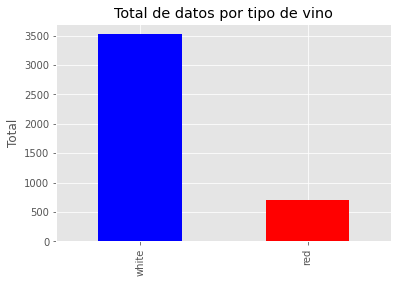

In [9]:
# conteo de datos separado por la columna type
ax = wineQuality["type"].value_counts().plot.bar(color=["blue", "red"])

ax.set_ylabel("Total")
ax.set_title("Total de datos por tipo de vino")
ax.set_xticklabels(["white", "red"])
plt.show()

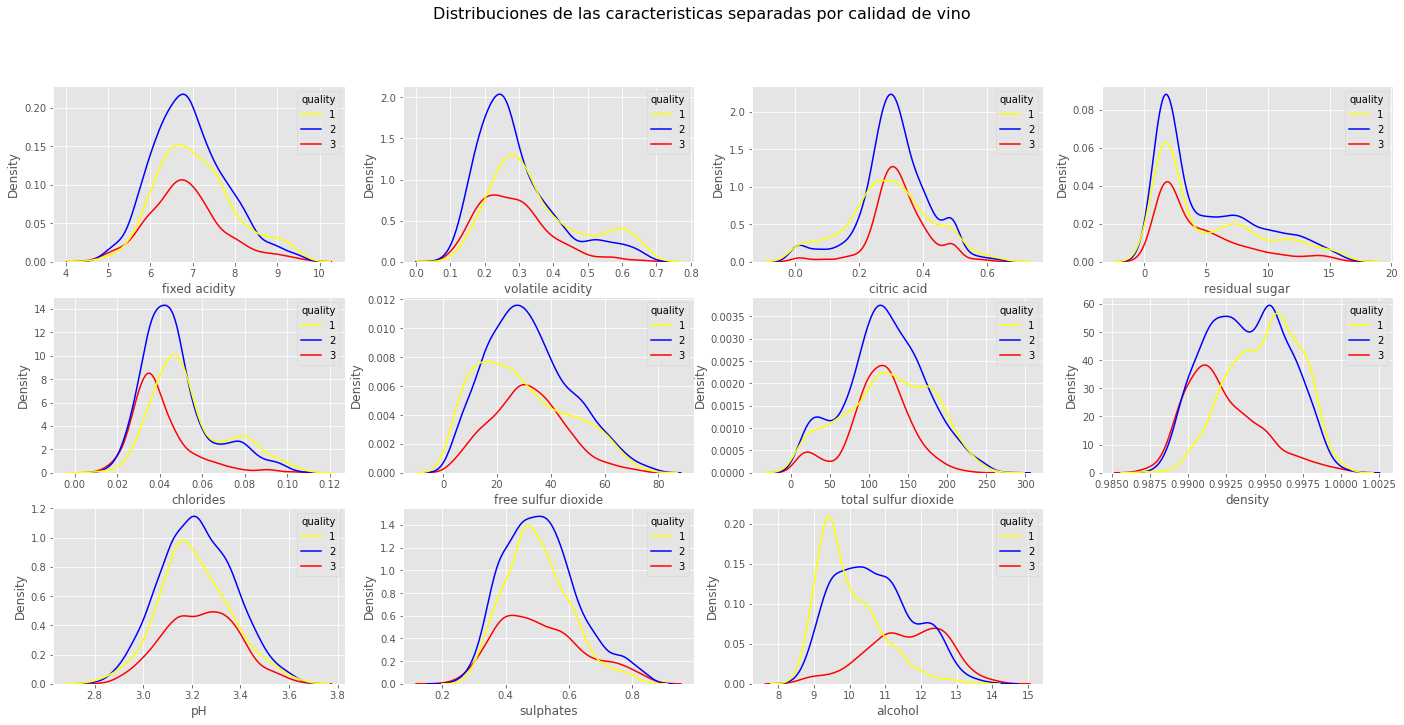

In [10]:
# Distribucion de las columnas
fig, axes = plt.subplots(3, 4, figsize=(24,11))
axes = axes.flatten()

# graficar la distribucion de las variables separadas por tipo de vino menos la variable objetivo
for i in range(wineQuality.columns.size - 2):
    sb.kdeplot(data=wineQuality, x=wineQuality.columns[i], hue="quality", ax=axes[i], palette=["yellow", "blue", "red"])

axes[-1].remove()

plt.suptitle("Distribuciones de las caracteristicas separadas por calidad de vino", fontsize=16)
plt.show()

## Descripcion de la variable objetivo

Dadas las anteriores caracteristicas se quiere clasificar un vino con base a la caracteristica objetivo "quality", la cual se tiene las siguientes clases:
- Clase 1 (vinos muy malos)
- Clase 2 (vinos promedio tirando a malo)
- Clase 3 (vinos promedio)
- Clase 4 (vinos promedio tirando a bueno)
- Clase 5 (vinos muy buenos)

|variable| tipo |
|--------|----------|
|quality|categorica (1,2,3,4,5)|

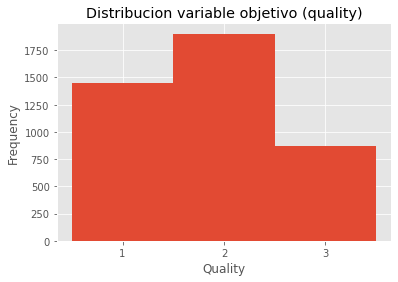

In [11]:
# distribucion de la variable objetivo
ax = wineQuality.quality.plot.hist(range=(0.5,3.5), bins=3, align="mid")

ax.set_xticks([1, 2, 3])
plt.title("Distribucion variable objetivo (quality)")
plt.xlabel("Quality")
plt.show()

de la grafica anterior se ve que es necesario balancear las clases, lo cual se hara usando el metodo SMOTE y se hara despues de separar el dataset en entrenamiento y prueba, para evitar que informacion del dataset de entrenamiento pase al datset de prueba y genere scores altos artificialmente.

# 2. Seleccion entre las metricas "entropy" y "gini"

In [12]:
# se validara que criterio es mejor usando los parametros para el modelo como estaban en los talleres y ejemplos

X = wineQuality.drop(columns="quality").copy()
y = wineQuality.quality.copy()

X_data = np.array(X)
y_data = np.array(y)

max_deep = X_data.shape[1] # maxima profundidad igual al numero de caracteristicas

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)   # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                    # Lo prueba con n-1 holds restantnes,
# para gini ---------------------------------------------------------------------------------------------------------------------------------
accuracies = []
# Testearemos la profundidad de 1 a cantidad de atributos
for depth in range(1, max_deep+1):
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion="gini",
                                        min_samples_split=20,
                                        min_samples_leaf=5,
                                        max_depth = depth,
                                        random_state=1)
    for train_index, valid_index in cv.split(X_data, y_data):
        X_tr, X_te = X_data[train_index], X_data[valid_index]    #Validación cruzada.
        y_tr, y_te = y_data[train_index], y_data[valid_index]

        # balanceo de clases usando SMOTE
        X_tr, y_tr = SMOTE(random_state=1).fit_resample(X_tr, y_tr)

        tree_model.fit(X_tr, y_tr)
        valid_acc = tree_model.score(X_te, y_te) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos el promedio para cada profundidad
    accuracies.append(np.mean(fold_accuracy))
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Depth": range(1, max_deep+1), "avg acc gini": accuracies})
acc_gini = df.set_index("Depth")

# para entropy ------------------------------------------------------------------------------------------------------------------------
accuracies = []
# Testearemos la profundidad de 1 a cantidad de atributos
for depth in range(1, max_deep+1):
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion="entropy",
                                        min_samples_split=20,
                                        min_samples_leaf=5,
                                        max_depth = depth,
                                        random_state=1)
    
    for train_index, valid_index in cv.split(X_data, y_data):
        X_tr, X_te = X_data[train_index], X_data[valid_index]    #Validación cruzada.
        y_tr, y_te = y_data[train_index], y_data[valid_index]

        # balanceo de clases usando SMOTE
        X_tr, y_tr = SMOTE(random_state=1).fit_resample(X_tr, y_tr)

        tree_model.fit(X_tr, y_tr)
        valid_acc = tree_model.score(X_te, y_te) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos el promedio para cada profundidad
    accuracies.append(np.mean(fold_accuracy))
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Depth": range(1, max_deep+1), "avg acc entropy": accuracies})
acc_entropy = df.set_index("Depth")
# ------------------------------------------------------------------------------------------------------------------------

r = pd.concat([acc_gini, acc_entropy], axis="columns")
r

,avg acc gini,avg acc entropy
Depth,,
1,0.442019,0.442019
2,0.484366,0.482707
3,0.496676,0.488395
4,0.525073,0.512300
5,0.524594,0.508987
6,0.523642,0.515128
7,0.522230,0.509916
8,0.524599,0.512767
9,0.521761,0.509920


In [13]:
# exactitud promedio de todas las profundidades
r.mean()

avg acc gini       0.509258
avg acc entropy    0.501561
dtype: float64

Aunque no varian mucho los datos, parece ser que el criterio "gini" da mejores resultados con una profundidad de 4, y ademas en promedio da una exactitud mayor que el criterio entropy.

# 3. Porcentaje de datos para entrenamiento y prueba

In [14]:
porc_train = np.arange(0.6, 0.9, 0.05) # porcentajes para entrenamiento a probar

# modelo con parametros por defecto excepto criterion
model = DecisionTreeClassifier(criterion="gini", random_state=1)
for p in porc_train:
    # split en entrenamiento y prueba
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=p, random_state=1)

    # balanceo de clases usando SMOTE
    X_tr, y_tr = SMOTE(random_state=1).fit_resample(X_tr, y_tr)

    model.fit(X_tr, y_tr)
    acc = model.score(X_te, y_te)

    print(f"Exactitud usando {round(p*100)}% datos para entrenamiento y {round((1-p)*100)}% para prueba => {round(acc,5)}")

Exactitud usando 60% datos para entrenamiento y 40% para prueba => 0.49083
Exactitud usando 65% datos para entrenamiento y 35% para prueba => 0.48514
Exactitud usando 70% datos para entrenamiento y 30% para prueba => 0.5
Exactitud usando 75% datos para entrenamiento y 25% para prueba => 0.50331
Exactitud usando 80% datos para entrenamiento y 20% para prueba => 0.49054
Exactitud usando 85% datos para entrenamiento y 15% para prueba => 0.52524
Exactitud usando 90% datos para entrenamiento y 10% para prueba => 0.50827


Se probo entrenando modelos con criterion = 'gini' (como se encontro en el punto anterior) usando 60%, 65%, 70%, 75% y 80% de los datos como datos de entrenamiento y el resto como datos de prueba, los mejores resultados se obtuvieron usando 85% de los datos para entrenamiento y 15% para prueba por lo que estos seran usados para el modelo final.

# 4. Variables a usar en la clasificacion

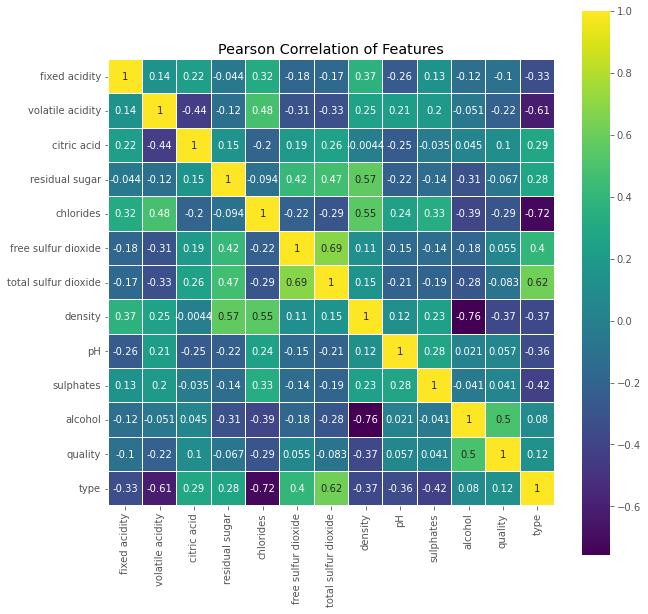

In [15]:
# matriz de correlaciones de pearson (nuestros datos son numericos, solo hay una variable categorica)
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features')
sb.heatmap(wineQuality.corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)
plt.show()

In [16]:
# selectKbest
kbest = SelectKBest(k="all").fit(X, y)

kbest = pd.Series(kbest.scores_, index=kbest.feature_names_in_).sort_values(ascending=False)

print("scores de las variables segun SelectKbest \n")
kbest

scores de las variables segun SelectKbest 



alcohol                 695.994842
density                 347.314535
chlorides               201.195934
volatile acidity        127.948206
type                     32.418701
fixed acidity            23.765499
citric acid              22.976954
total sulfur dioxide     15.657264
residual sugar           11.561307
free sulfur dioxide      11.089748
pH                        6.959549
sulphates                 4.834656
dtype: float64

observando la matriz de correlaciones se observan algunas correlaciones considerables entre variables, pero no es nada muy grave por lo que no se tomaran medidas al respecto. Basados en el metodo de select K best se eliminaran las columnas PH y sulphates a modo de reducir la dimensionalidad de los datos, ya que estas variables presentan las menores importancias para la clasificacion de quality.


In [17]:
selected = [
    'alcohol',
    'density',
    'chlorides',
    'volatile acidity',
    'type',
    'fixed acidity',
    'citric acid',
    'total sulfur dioxide',
    'residual sugar',
    'free sulfur dioxide'
]

# 5. Seleccion de profundidad del arbol

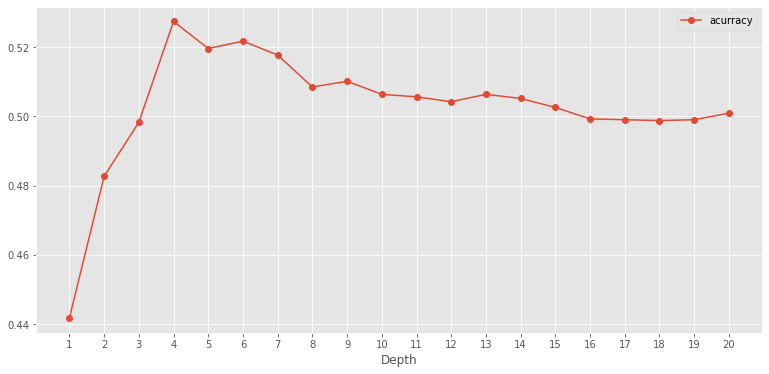

In [18]:
X_data = np.array(X[selected])
y_data = np.array(y)

max_deep = 20 # maxima profundidad del arbol a probar

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)   # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                    # Lo prueba con n-1 holds restantnes,

accuracies = []
for depth in range(1, max_deep+1):
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion="gini",
                                        min_samples_split=20,
                                        min_samples_leaf=5,
                                        max_depth = depth,
                                        random_state=1)
    for train_index, valid_index in cv.split(X_data, y_data):
        X_tr, X_te = X_data[train_index], X_data[valid_index]    #Validación cruzada.
        y_tr, y_te = y_data[train_index], y_data[valid_index]

        # balanceo de clases usando SMOTE
        X_tr, y_tr = SMOTE(random_state=1).fit_resample(X_tr, y_tr)

        tree_model.fit(X_tr, y_tr)
        valid_acc = tree_model.score(X_te, y_te) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos el promedio para cada profundidad
    accuracies.append(np.mean(fold_accuracy))
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Depth": range(1, max_deep+1), "acurracy": accuracies})
depths = df.set_index("Depth")

ax = depths.plot.line(marker="o", figsize=(13,6))

ax.set_xticks(depths.index)

plt.show()

De la grafica se ve que a partir de una profundidad de 4 para el arbol, no mejora la exactitud, por lo que lo mas adecuado para nuestro trabajo sera trabajar con altura 4 del arbol

# 6. cantidad mínima de muestras por nodo para dividir y el mínimo de muestras en cada hoja, grafica del arbol de decision creado

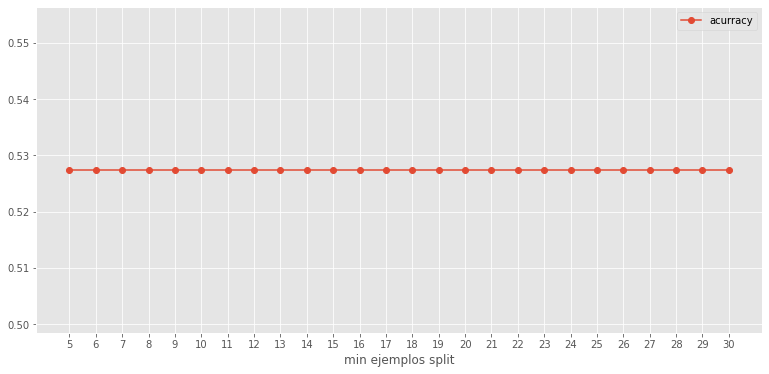

In [19]:
# probar muestras por nodo
X_data = np.array(X[selected])
y_data = np.array(y)

min_nodo_split = 30 # valores a probar

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)   # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                    # Lo prueba con n-1 holds restantnes,

accuracies = []
for nodo_split in range(5, min_nodo_split+1):
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion="gini",
                                        min_samples_split=nodo_split,
                                        min_samples_leaf=5,
                                        max_depth = 4,
                                        random_state=1)
    for train_index, valid_index in cv.split(X_data, y_data):
        X_tr, X_te = X_data[train_index], X_data[valid_index]    #Validación cruzada.
        y_tr, y_te = y_data[train_index], y_data[valid_index]

        # balanceo de clases usando SMOTE
        X_tr, y_tr = SMOTE(random_state=1).fit_resample(X_tr, y_tr)

        tree_model.fit(X_tr, y_tr)
        valid_acc = tree_model.score(X_te, y_te) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos el promedio para cada profundidad
    accuracies.append(np.mean(fold_accuracy))
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"min ejemplos split": range(5, min_nodo_split+1), "acurracy": accuracies})
nodo_split = df.set_index("min ejemplos split")

ax = nodo_split.plot.line(marker="o", figsize=(13,6))

ax.set_xticks(nodo_split.index)

plt.show()

Como se observa en la grafica, dentro del rango de los valores probados, este parametro no parece tener ningun impacto en la exactitud del modelo, por lo que se escogera para este un valor arbitrario de 15

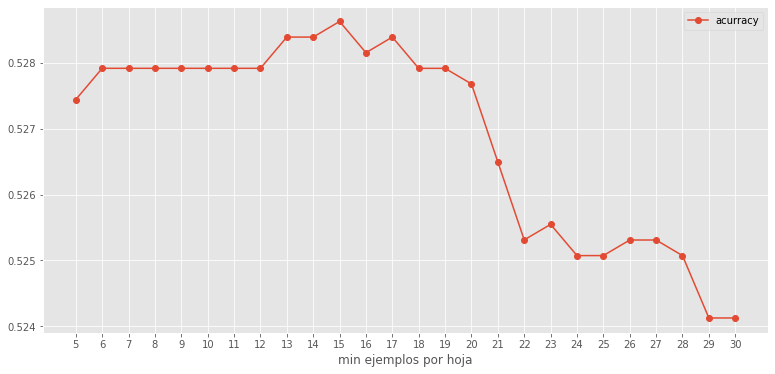

In [20]:
# probar muestras por nodo
X_data = np.array(X[selected])
y_data = np.array(y)

min_ejem_hoja = 30 # valores a probar

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)   # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                    # Lo prueba con n-1 holds restantnes,

accuracies = []
for sample_leaf in range(5, min_ejem_hoja+1):
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion="gini",
                                        min_samples_split=15,
                                        min_samples_leaf=sample_leaf,
                                        max_depth = 4,
                                        random_state=1)
    for train_index, valid_index in cv.split(X_data, y_data):
        X_tr, X_te = X_data[train_index], X_data[valid_index]    #Validación cruzada.
        y_tr, y_te = y_data[train_index], y_data[valid_index]

        # balanceo de clases usando SMOTE
        X_tr, y_tr = SMOTE(random_state=1).fit_resample(X_tr, y_tr)

        tree_model.fit(X_tr, y_tr)
        valid_acc = tree_model.score(X_te, y_te) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos el promedio para cada profundidad
    accuracies.append(np.mean(fold_accuracy))
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"min ejemplos por hoja": range(5, min_ejem_hoja+1), "acurracy": accuracies})
ejem_hoja = df.set_index("min ejemplos por hoja")

ax = ejem_hoja.plot.line(marker="o", figsize=(13,6))

ax.set_xticks(ejem_hoja.index)

plt.show()

Se escogera 15 como minimo de ejemplos por hoja en base al criterio de la exactitud, ya que como se ve en la grafica tiene la mejor exactitud de los valores probados.

### balanceo de la variable objetivo

In [21]:
# balanceo de clases

porc_split = 0.85 # porcion de los datos de entranamiento escogido en el punto 3

X = wineQuality[selected].copy()
y = wineQuality.quality.copy()

# split de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=porc_split, random_state=1)

# balanceo de clases usando SMOTE
X_train, y_train = SMOTE(random_state=1).fit_resample(X_train, y_train)

print("ejemplos por clase despues del balanceo")
y_train.value_counts()

ejemplos por clase despues del balanceo


2    1626
1    1626
3    1626
Name: quality, dtype: int64

se realizo un balanceo de clases usando el metodo SMOTE ya que como se vio en la grafica de distribucion de la variable objetivo, esta estaba desbalanceada, a demas se uso este metodo ya que para la clasificacion bayesiana tambien se busca tener clases balanceadas. Por ultimo se realizo el balanceo sobre el dataset de entrenamiento para evitar introducir informacion del dataset de entrenamiento al de prueba.

In [22]:
# entrenar modelo con los parametros escogidos
DTmodel = DecisionTreeClassifier(criterion="gini", min_samples_split=15, min_samples_leaf=15, max_depth = 4, random_state=1)
DTmodel.fit(X_train, y_train)

# display(DTmodel.score(X_test, y_test), DTmodel.score(X_train, y_train))

DecisionTreeClassifier(max_depth=4, min_samples_leaf=15, min_samples_split=15,
                       random_state=1)

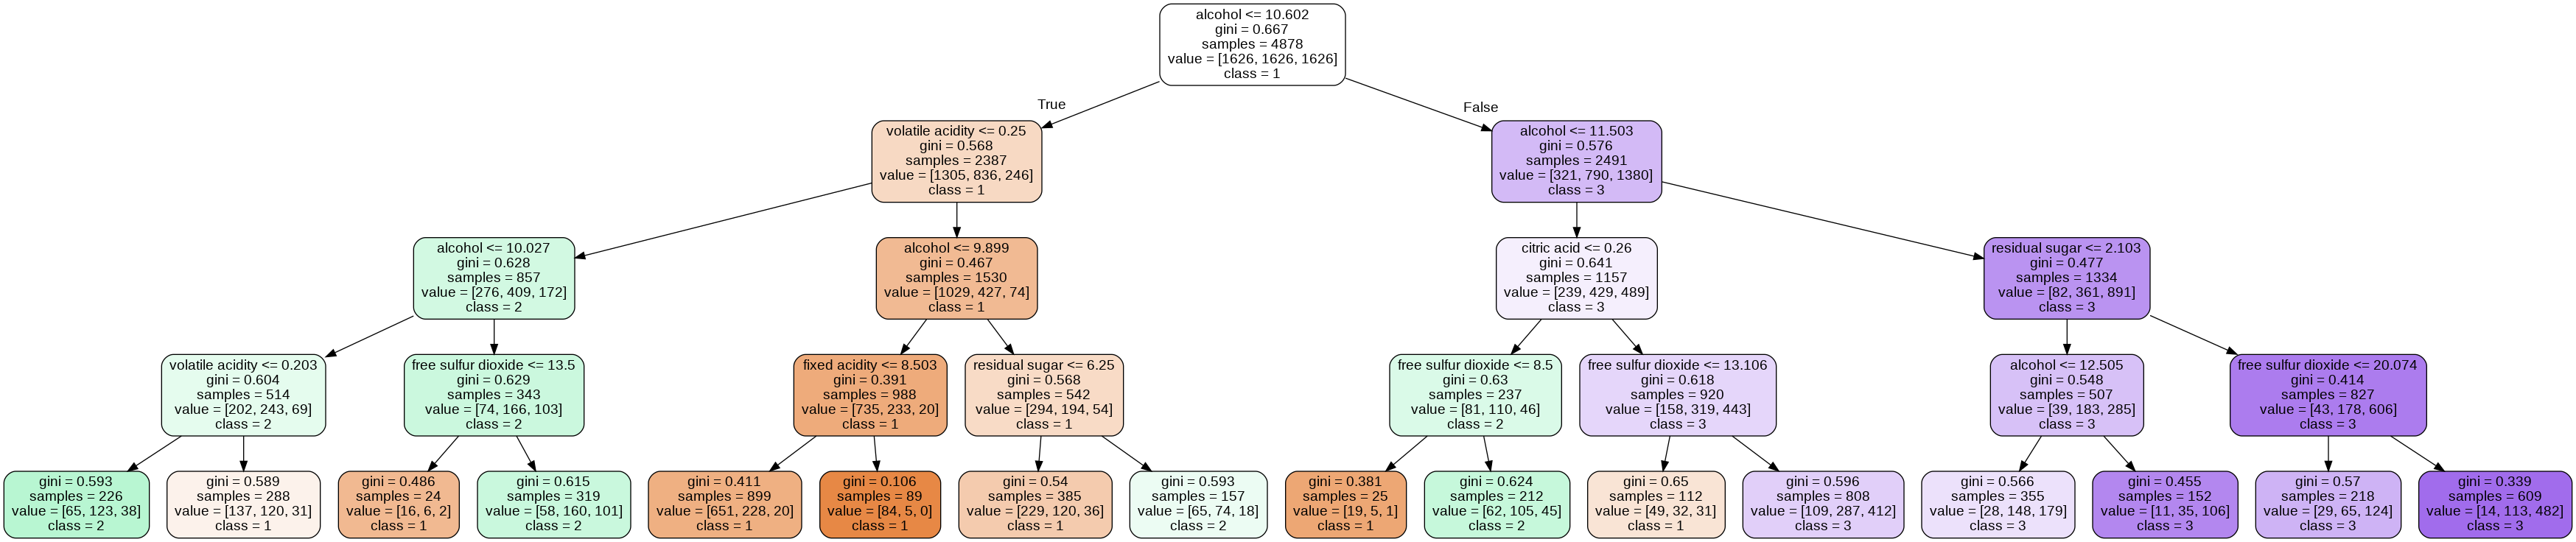

In [23]:
from sklearn import tree
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

with open(r"tree1.dot", 'w') as f:
    f = tree.export_graphviz(DTmodel,
                             out_file=f,
                             max_depth = 4,
                             impurity = True,
                             feature_names = selected,
                             class_names = ["1", "2", "3"],
                             rounded = True,
                             filled= True)
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

### Caracteristica escogida como nodo raiz

como se ve en el arbol, la caracteristica escogida como nodo raiz es **alcohol**, esta caracteristica tambien fue escogida como nodo raiz por SelectKbest, y en la matriz de correlaciones de pearson esta caracteristica es la que mas esta correlacionada con la variable objetivo, a demas que tambien en las graficas de distribucion de esta variable se ve que es la variable que mejor diferencia a cada una de las clases de quality.

# 7. Matriz de confusión

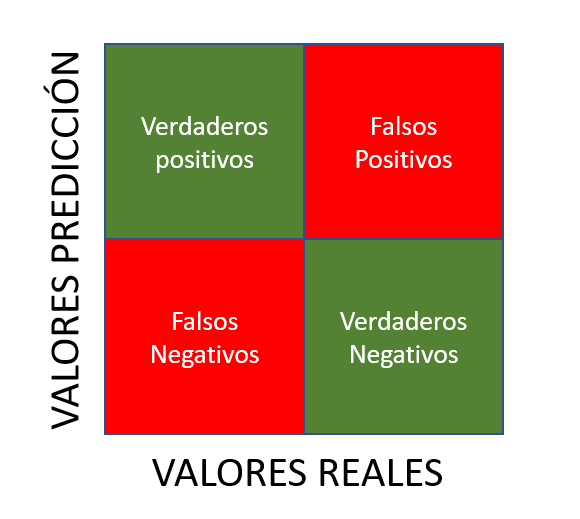


* (**Verdadero positivo**): Valor que es verdad y que el modelo predijo correctamente.
* (**Falso negativo**): Valor que es verdad y el modelo predijo incorrectamente.
* (**Falso positivo**): Valor que no es verdad y que el modelo predijo incorrectamente.
* (**Verdadero negativo**): Valor que no es verdad y que el modelo predijo correctamente.

# Datos de entrenamiento.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


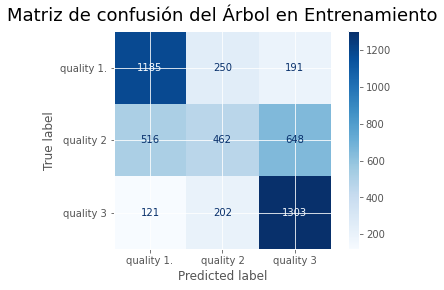

In [24]:
#Matriz de confuncion para train
disp = plot_confusion_matrix(DTmodel, X_train, y_train,
                                 display_labels=['quality 1.','quality 2','quality 3'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Entrenamiento', y=1.02, size=18)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


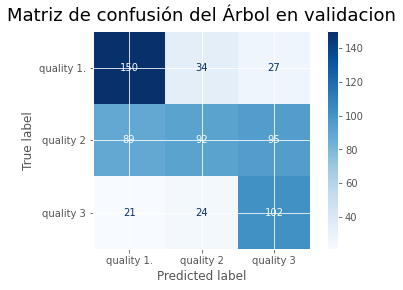

In [25]:
#Matriz de confuncion para train
disp = plot_confusion_matrix(DTmodel, X_test, y_test,
                                 display_labels=['quality 1.','quality 2','quality 3'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en validacion', y=1.02, size=18)

plt.show()

# 8. Exactitud del árbol con datos de entrenamiento

In [26]:
y_pred_train = DTmodel.predict(X_train)

In [27]:
acc_train = accuracy_score(y_train, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 0.60


### Exactitud del árbol con datos de prueba

In [28]:
y_pred_test = DTmodel.predict(X_test)

In [29]:
acc_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.54


# 9. F1-Score, precision, recall

### Datos de entrenamiento

In [30]:
decoded_y_test = y_train
decoded_predictions = DTmodel.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.65      0.73      0.69      1626
           2       0.51      0.28      0.36      1626
           3       0.61      0.80      0.69      1626

    accuracy                           0.60      4878
   macro avg       0.59      0.60      0.58      4878
weighted avg       0.59      0.60      0.58      4878



#### Datos de prueba

In [31]:
decoded_y_test = y_test
decoded_predictions = DTmodel.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.58      0.71      0.64       211
           2       0.61      0.33      0.43       276
           3       0.46      0.69      0.55       147

    accuracy                           0.54       634
   macro avg       0.55      0.58      0.54       634
weighted avg       0.56      0.54      0.53       634



## 10. Clasificación bayesiana.

In [32]:
#Ajustando el modelo
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train,
    y_train
)
y_pred = gnb.predict(X_test)
 
print('Accuracy in training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy in test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))


Accuracy in training set: 0.55
Accuracy in test set: 0.46


al comparar el arbol de decision con la clasificacion bayesiana se obtiene la siguiente tabla resumen:

|Modelo|exac. entrenamiento|exac. prueba|
|------|---------|------------|
|Arbol de decicion|0.60|0.54|
|Gaussian naive bayes|0.55|0.46|

Basados en estos resultados podemos decir que el arbol de decision obtuvo un mejor desempeño tanto en entrenamiento como en prueba que la clasificacion bayesiana

### Matriz de confusión.

#### Entrenamiento.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


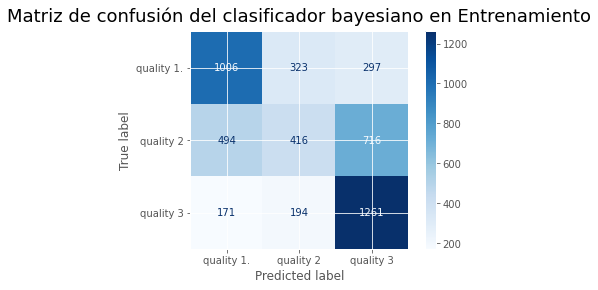

In [33]:
disp = plot_confusion_matrix(gnb, X_train, y_train,
                                 display_labels=['quality 1.','quality 2','quality 3'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del clasificador bayesiano en Entrenamiento', y=1.02, size=18)

plt.show()

#### Prueba.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


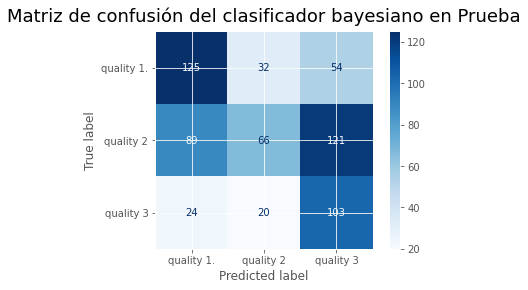

In [34]:
disp = plot_confusion_matrix(gnb, X_test, y_test,
                                 display_labels=['quality 1.','quality 2','quality 3'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del clasificador bayesiano en Prueba', y=1.02, size=18)

plt.show()

### F1-Score

#### Entrenamiento.

In [35]:
decoded_y_test = y_train
decoded_predictions = gnb.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.60      0.62      0.61      1626
           2       0.45      0.26      0.33      1626
           3       0.55      0.78      0.65      1626

    accuracy                           0.55      4878
   macro avg       0.53      0.55      0.53      4878
weighted avg       0.53      0.55      0.53      4878



#### Prueba.

In [36]:
decoded_y_test = y_test
decoded_predictions = gnb.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.53      0.59      0.56       211
           2       0.56      0.24      0.34       276
           3       0.37      0.70      0.48       147

    accuracy                           0.46       634
   macro avg       0.49      0.51      0.46       634
weighted avg       0.50      0.46      0.44       634



# 11. Analisis de resultados y conclusiones

Basados en los resultados obtenidos en este trabajo se puede concluir que:
- Inicialmente teniamos 10 categorias de la variable objetivo pero esta estaba muy desbalanceada, por lo que se decidio agrupar estas categorias de modo que terminamos con 3 categorias (tal y como se explica en la seccion de preprocesamiento de esta libreta), aun despues de dicho agrupamiento las clases seguian desbalanceadas por lo que se uso el metodo SMOTE para hacer un oversampling sobre las categorias que tenian menos datos.
- Se encontro que la caracteristica que mas importancia tenia a la hora de determinar la categoria de quality para los vinos era alcohol, y por lo tanto fue elegida como nodo raiz del arbol de decision. las caracteristicas pH y sulphates fueron eliminadas para reducir la dimensionalidad de los datos y obtener un modelo mas parsimonioso, ya que eran las que menor importancia presentaban para determinar el quality de los vinos.
- Se encontro que los hiperparametros que tenian un mejor desempeño para el arbol de decision fueron:
    - criterion: gini. aunque las diferencias eran minimas, este consiguio un mejor desempeño en promedio.
    - max_depth: 4. una profundidad de 4 para el arbol de decision era la profundidad que mejores resultados da para nuestros datos.
    - min_samples_split: sorprendentemente segun los resultados obtenidos, en el rango probado, este hiperparametro parecia no tener relevancia a la hora de mejorar los resultados del modelo, por lo que se escogio arbitrariamente el valor de 15.
    - min_samples_leaf: 15: un minimo de ejemplos por hoja de 15 para el arbol de decision es el que mejores resultados da para nuestros datos.
- Se encontro que la particion de los datos en entrenamiento y prueba que mejor resultado daba era 85% para entrenamiento y 15% para prueba.
- De las matrices de confusion para el arbol de decision tanto para entrenamiento como para prueba se oberva que el modelo se tiende a equivocarse mucho mas clasificando los vinos de categoria 2 (vinos promedio), esto probablemente debido a una mayor dispersion de las caracteristicas para esta categoria de quality.
- Observando las tablas resumen que presentan Precision, Recall y F1 score se confirma lo observado en las matrices de confusion, el arbol de decision tiene un peor desempeño clasificando los vinos de quality = 2
- De los dos modelos entrenados, el arbol de decision obtuvo un mejor desempeño tanto en entrenamiento como en prueba, por lo que entre estos dos modelos se prefiere el arbol de decision.

<center>

|Modelo|exac. entrenamiento|exac. prueba|
|------|---------|------------|
|Arbol de decicion|0.60|0.54|
|Gaussian naive bayes|0.55|0.46|

</center>

- El modelo de clasificacion bayesiana tambien tiene el problema de clasificar peor quality = 2, pero a demas de eso tambien se equivoca mas clasificando quality = 3, como se ve en las matrices de confusion y las tablas resumen de Precision, Recall y F1 score.
- Finalmente los modelos vistos en este trabajo no cumplen con las expectativas que se pudieran tener para un modelo que fuera a funcionar en un ambiente laboral, por lo que se recomienda probar con otros modelos que pudieran alcanzar un desempeño mas satisfactorio.
